# CIND 820 Project


Text pre-processing / EDA

In [1]:
#Install and import necessary libraries
!pip install textblob
!pip install nrclex
!python -m textblob.download_corpora
from textblob import TextBlob
from nrclex import NRCLex
import nltk
from nltk.corpus import stopwords

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [2]:

#Download the dataset
import requests
import zipfile
import io

# Download the ZIP file
url = "https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip"
response = requests.get(url)

# Unzip the file into memory
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.printdir()
    # Assuming a CSV file inside:
    with z.open("Fake.csv") as f:
        fake_news = pd.read_csv(f)
    with z.open("True.csv") as f:
        real_news = pd.read_csv(f)

# Add 'Credibility' column
fake_news['authenticity'] = 0  # 0 for fake news
real_news['authenticity'] = 1  # 1 for real news



File Name                                             Modified             Size
Fake.csv                                       2018-03-12 16:20:52     62789876
True.csv                                       2018-03-12 16:21:36     53582940


In [3]:
# Combine the datasets
df = pd.concat([fake_news, real_news], ignore_index=True)
# Display the first and last few rows of the combined dataset to verify
print(df.head())
print(df.tail())

# Display the info to check data types and non-null counts
df.info()

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  authenticity  
0  December 31, 2017             0  
1  December 31, 2017             0  
2  December 30, 2017             0  
3  December 29, 2017             0  
4  December 25, 2017             0  
                                                   title

## Data Cleaning

In [4]:
# Drop the 'title' and 'subject' columns from the dataframe
df = df.drop(['title', 'subject'], axis=1)
df.tail()


,text,date,authenticity
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,"August 22, 2017",1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...","August 22, 2017",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,"August 22, 2017",1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,"August 22, 2017",1
44897,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,"August 22, 2017",1


In [5]:
#NRC Emotions list
nrc_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'negative', 'positive', 'sadness', 'surprise', 'trust']

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
def basic_cleaning(text):
    text = str(text).lower()
    # text = expand_contractions(text)
    text = re.sub(r"http\S+|www.\S+", "", text)           # remove URLs
    text = re.sub(r"\d{1,2}/\d{1,2}/\d{2,4}", "", text)    # remove dates like 12/31/2022
    text = re.sub(r"\d{4}-\d{2}-\d{2}", "", text)          # remove dates like 2022-12-31
    text = re.sub(r"\breuters\b", "", text)               # remove the word "reuters"
    text = re.sub(r"'s\b", "", text)                      # remove possessive 's
    text = re.sub(r"\d+", "", text)                       # remove numbers
    text = re.sub(r"[^\w\s]", "", text)                   # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()              # remove extra whitespace
    return text

# TextBlob-based lemmatization
def preprocess_text(text):
    cleaned = basic_cleaning(text)
    blob = TextBlob(cleaned)
    filtered = [word for word in blob.words if word.lower() not in stop_words] # remove stopwords
    lemmatized = ' '.join([word.lemmatize() for word in filtered])
    return lemmatized

# TextBlob sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# NRC Emotion Lexicon — convert to fixed-score vector
def get_emotion_vector(text):
    emotions = NRCLex(text).raw_emotion_scores
    return [emotions.get(e, 0) for e in nrc_emotions]

def count_emotion_words(text):
    emotions = NRCLex(text).raw_emotion_scores
    return sum(emotions.values())

# Total number of words in the cleaned text
def count_total_words(text):
    return len(TextBlob(text).words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Clean and lemmatize
df['text_clean'] = df['text'].apply(preprocess_text)

# Sentiment
df[['text_polarity', 'text_subjectivity']] = df['text_clean'].apply(lambda x: pd.Series(get_sentiment(x)))

df['emotion_word_count'] = df['text_clean'].apply(count_emotion_words)
df['total_word_count'] = df['text'].apply(count_total_words)

# Emotions: one column per emotion
text_emotion_df = df['text_clean'].apply(lambda x: pd.Series(get_emotion_vector(x), index=[f"{e}" for e in nrc_emotions]))

# Combine with original DataFrame
df = pd.concat([df, text_emotion_df], axis=1)


In [7]:
print(df.tail())
df.info()

                                                    text              date  \
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  August 22, 2017    
44894  LONDON (Reuters) - LexisNexis, a provider of l...  August 22, 2017    
44895  MINSK (Reuters) - In the shadow of disused Sov...  August 22, 2017    
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  August 22, 2017    
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  August 22, 2017    

       authenticity                                         text_clean  \
44893             1  brussels nato ally tuesday welcomed president ...   
44894             1  london lexisnexis provider legal regulatory bu...   
44895             1  minsk shadow disused sovietera factory minsk s...   
44896             1  moscow vatican secretary state cardinal pietro...   
44897             1  jakarta indonesia buy sukhoi fighter jet worth...   

       text_polarity  text_subjectivity  emotion_word_count  total_word_count  \
44893

In [8]:
# export pre-processed df to csv
df.to_csv('output_dataframe.csv', index=False)
print("DataFrame successfully exported to output_dataframe.csv")

DataFrame successfully exported to output_dataframe.csv


In [9]:
# Normalize emotion columns by dividing by total_word_count
for emotion in nrc_emotions:
  df[f'{emotion}_normalized'] = df[emotion] / df['total_word_count']

# Handle potential division by zero (replace inf or NaN with 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.fillna(0, inplace=True)


# Select only the normalized emotion columns for scaling
normalized_emotion_columns = [f'{e}_normalized' for e in nrc_emotions]
emotion_data = df[normalized_emotion_columns]

print(df.head())
print(df.tail())
df.info()


                                                text               date  \
0  Donald Trump just couldn t wish all Americans ...  December 31, 2017   
1  House Intelligence Committee Chairman Devin Nu...  December 31, 2017   
2  On Friday, it was revealed that former Milwauk...  December 30, 2017   
3  On Christmas day, Donald Trump announced that ...  December 29, 2017   
4  Pope Francis used his annual Christmas Day mes...  December 25, 2017   

   authenticity                                         text_clean  \
0             0  donald trump wish american happy new year leav...   
1             0  house intelligence committee chairman devin nu...   
2             0  friday revealed former milwaukee sheriff david...   
3             0  christmas day donald trump announced would bac...   
4             0  pope francis used annual christmas day message...   

   text_polarity  text_subjectivity  emotion_word_count  total_word_count  \
0       0.115306           0.603401                

In [10]:

print('Article length statistics:')
print(df.groupby('authenticity')['total_word_count'].describe())


Article length statistics:
                count        mean        std  min    25%    50%    75%     max
authenticity                                                                  
0             23481.0  424.915038  410.03057  0.0  240.0  365.0  507.0  8141.0
1             21417.0  395.302377  283.59143  0.0  150.0  367.0  536.0  5426.0


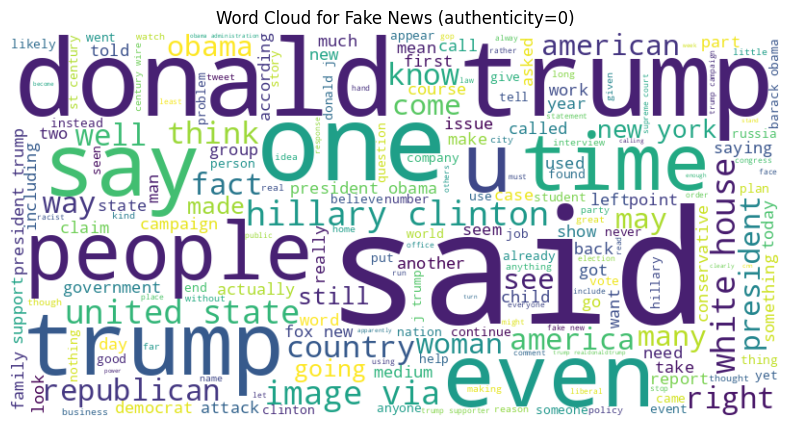

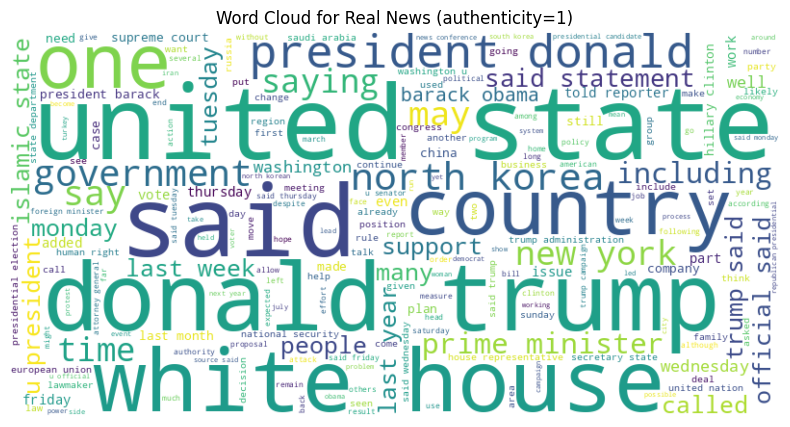

In [15]:
!pip install wordcloud
from wordcloud import WordCloud

# Combine all text for each authenticity group
fake_text = " ".join(df[df['authenticity'] == 0]['text_clean'].dropna())
real_text = " ".join(df[df['authenticity'] == 1]['text_clean'].dropna())

# Generate word cloud for fake news
wordcloud_fake = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(fake_text)

# Plot the word cloud for fake news
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News (authenticity=0)')
plt.show()

# Generate word cloud for real news
wordcloud_real = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(real_text)

# Plot the word cloud for real news
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News (authenticity=1)')
plt.show()

In [12]:
# Normalize emotion columns by dividing by total_word_count
for emotion in nrc_emotions:
  df[f'{emotion}_normalized'] = df[emotion] / df['total_word_count']

# Handle potential division by zero (replace inf or NaN with 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.fillna(0, inplace=True)


# Select only the normalized emotion columns for scaling
normalized_emotion_columns = [f'{e}_normalized' for e in nrc_emotions]
emotion_data = df[normalized_emotion_columns]

print(df.head())
print(df.tail())
df.info()


                                                text               date  \
0  Donald Trump just couldn t wish all Americans ...  December 31, 2017   
1  House Intelligence Committee Chairman Devin Nu...  December 31, 2017   
2  On Friday, it was revealed that former Milwauk...  December 30, 2017   
3  On Christmas day, Donald Trump announced that ...  December 29, 2017   
4  Pope Francis used his annual Christmas Day mes...  December 25, 2017   

   authenticity                                         text_clean  \
0             0  donald trump wish american happy new year leav...   
1             0  house intelligence committee chairman devin nu...   
2             0  friday revealed former milwaukee sheriff david...   
3             0  christmas day donald trump announced would bac...   
4             0  pope francis used annual christmas day message...   

   text_polarity  text_subjectivity  emotion_word_count  total_word_count  \
0       0.115306           0.603401                

/tmp/ipython-input-13-1445378667.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_count_distribution.index, y=word_count_distribution.values, palette='viridis')


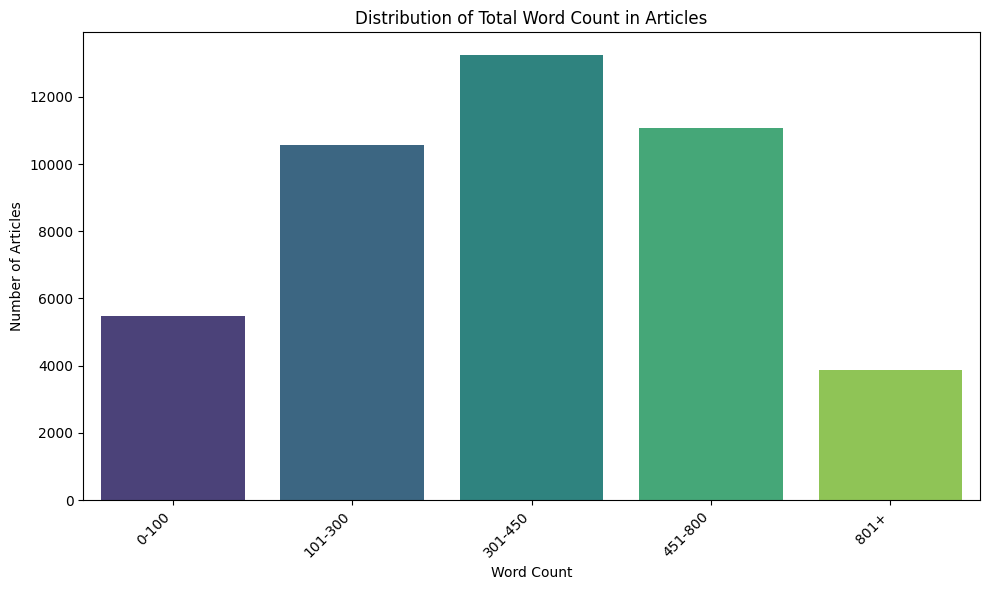

In [13]:
# Define the bins and labels for word count
bins = [0, 100, 300, 450, 800, float('inf')]
labels = ['0-100', '101-300', '301-450', '451-800', '801+']

# Create a new column 'word_count_bucket' by applying the bins to 'total_word_count'
df['word_count_bucket'] = pd.cut(df['total_word_count'], bins=bins, labels=labels, right=True)

# Count the occurrences in each bucket
word_count_distribution = df['word_count_bucket'].value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=word_count_distribution.index, y=word_count_distribution.values, palette='viridis')
plt.title('Distribution of Total Word Count in Articles')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()